# 0.0 IMPORTS

## packages

In [47]:
import os, pickle, datetime, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import models as ml
from keras import layers as l
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix


pd.options.display.max_columns = 500 # this will set limit of columns to 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\airbnb_prediction'

## 0.1 Helper Function

In [46]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 0.2 Loading Data

In [3]:
df0 = pd.read_csv("data/train_users_2.csv")
df0.columns = df0.columns.str.lower()
df0.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [4]:
df_sessions = pd.read_csv( "data/sessions.csv" )
df_sessions.columns = df_sessions.columns.str.lower()
df_sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.00000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.00000
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.00000


# 1.0 Data Description

In [63]:
df1 = df0.copy()

In [77]:
df_sessions1 = df_sessions.copy()

In [64]:
df1.shape

(213451, 16)

## 1.1 Check and Fill NAs

In [65]:
df1.isnull().sum()/len(df1)

id                        0.00000
date_account_created      0.00000
timestamp_first_active    0.00000
date_first_booking        0.58347
gender                    0.00000
age                       0.41223
signup_method             0.00000
signup_flow               0.00000
language                  0.00000
affiliate_channel         0.00000
affiliate_provider        0.00000
first_affiliate_tracked   0.02841
signup_app                0.00000
first_device_type         0.00000
first_browser             0.00000
country_destination       0.00000
dtype: float64

C:\Users\kosmo\AppData\Local\Temp\ipykernel_23296\3571433752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[df1['age']<65]['age'])


<Axes: xlabel='age', ylabel='Density'>

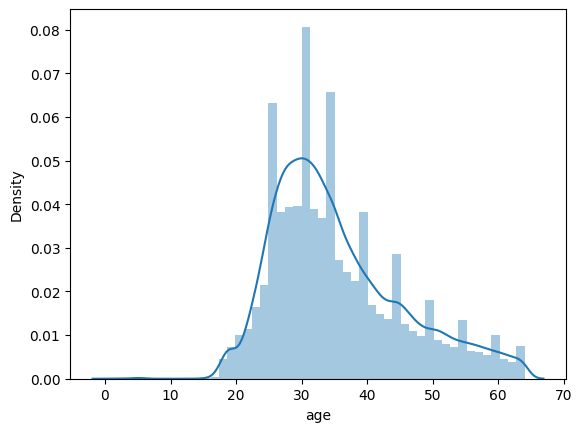

In [66]:
sns.distplot(df1[df1['age']<65]['age'])

In [67]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [68]:
# date first booking
for i in ["date_account_created", "date_first_booking"]:
    df1[i] = pd.to_datetime(df1[i])
date_first_booking_max = df1['date_first_booking'].max().strftime( "%Y-%m-%d" )
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1['age'] = df1['age'].fillna(df1['age'].mean())

print(df1['date_first_booking'].isnull().sum(), print(df1['age'].isnull().sum()))


# first_affiliate tracked
print( len(df1) )
df1 = df1[df1['first_affiliate_tracked'].notnull()]
print( len(df1) )

0
0 None
213451
207386


In [69]:
df1.isnull().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [78]:
df_sessions1.isnull().sum() / len(df_sessions1)

user_id         0.00326
action          0.00753
action_type     0.10657
action_detail   0.10657
device_type     0.00000
secs_elapsed    0.01287
dtype: float64

In [79]:
for i in df_sessions1.columns:
    df_sessions1 = df_sessions1[df_sessions1[i].notnull()]
    print( "tamanho:", len(df_sessions1))

tamanho: 10533241
tamanho: 10453761
tamanho: 9330804
tamanho: 9330804
tamanho: 9330804
tamanho: 9213930


## 1.2 Change Data Types

In [ ]:
df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )


In [38]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [39]:
for i in ["date_account_created", "date_first_booking"]:
    df1[i] = pd.to_datetime(df1[i])
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( "%Y-%m-%d" )
df1[ 'timestamp_first_active' ] = pd.to_datetime( df1['timestamp_first_active'], format="%Y%m%d%H%M%S" )
df1['age'] = df1['age'].astype(int)
print( df1.dtypes )

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [8]:
print( len(df1) )
df1 = df1.dropna()
print( len(df1) )

213451
68171


# 2.0 Data Filtering

In [11]:
df2 = df1.copy()

# 3.0 Data Prep

In [12]:
df3 = df2.copy()

#dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

#join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

# 4.0 Feature Selection

In [13]:
cols_drop = ['date_account_created', 'timestamp_first_active', "date_first_booking"]
df4 = df3.drop( cols_drop , axis=1)

# 5.0 Machine Learning Model

In [14]:
df5 = df4.copy()

In [15]:
X = df5.drop( ["country_destination","id"] , axis=1 )
y = df5['country_destination'].copy()

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split( X, y, test_size = 0.2, random_state=42 )

## 5.1 Baseline Model

In [17]:
country_list = np.sort(y.unique())
country_list

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [18]:
weights_country = y.value_counts(normalize=True).sort_index()
weights_country

AU      0.00637
CA      0.01570
DE      0.01245
ES      0.02486
FR      0.05408
GB      0.02593
IT      0.02976
NL      0.00880
PT      0.00232
US      0.70886
other   0.11085
Name: country_destination, dtype: float64

In [19]:
yhat_random = random.choices( population=country_list, weights=weights_country ,k=len(Xtest))

In [20]:
# accuracy

acc_nn = accuracy_score(ytest, yhat_random)

bacc_nn = balanced_accuracy_score(ytest, yhat_random)

kappa_nn = cohen_kappa_score(ytest, yhat_random)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)


0.522038870553722 
 0.08565789568932228 
 -0.0036210043120581403


Confusion matrix, without normalization
[[6908 1054  165  536  308  261  210   68  117   55   22]
 [1075  142   17   77   52   38   37   12   20    9    2]
 [ 150   22    2   12    4    6    4    3    4    2    1]
 [ 506   92   14   42   19   22   20    7   11    8    1]
 [ 289   49    7   22    8    9    7    1    4    2    1]
 [ 253   35    3   16   13    5    8    2    5    2    2]
 [ 247   34    5   28    9   12   10    2    4    2    3]
 [  74    9    2    7    4    7    2    0    1    1    0]
 [ 116   21    4    6    7    8    9    3    1    0    1]
 [  63    7    1    7    3    2    4    1    2    0    0]
 [  20    2    0    1    0    1    1    0    1    0    0]]


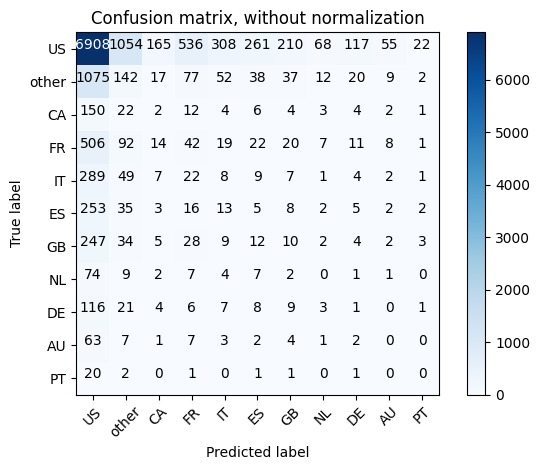

In [21]:
cnf_matrix = confusion_matrix(ytest, yhat_random,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

## 5.2 Neural Network Model

In [22]:

ohe = OneHotEncoder()
ytrain_nn = ohe.fit_transform( ytrain.values.reshape( -1, 1 ) ).toarray()


In [23]:
model = ml.Sequential()
model.add( l.Dense( 128, input_dim = Xtrain.shape[1], activation = "relu" ) )
model.add( l.Dense( 11, activation="softmax") )

#model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

#train model
model.fit( Xtrain, ytrain_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 5s 2ms/step - loss: 1.3523 - accuracy: 0.7031
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2695 - accuracy: 0.7057
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2382 - accuracy: 0.7068
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2124 - accuracy: 0.7069
Epoch 5/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1917 - accuracy: 0.7070
Epoch 6/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1753 - accuracy: 0.7069
Epoch 7/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1619 - accuracy: 0.7071
Epoch 8/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1559 - accuracy: 0.7071
Epoch 9/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1459 - accuracy: 0.7074
Epoch 10/100
1705/1705 [==============================] - 2s 1ms/step - l

# 6.0 NN Performance

In [24]:
# prediction
pred_nn = model.predict( Xtest )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
ytest_nn = ytest.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

427/427 [==============================] - 1s 3ms/step


In [25]:
# accuracy

acc_nn = accuracy_score(ytest_nn, yhat_nn)

bacc_nn = balanced_accuracy_score(ytest_nn, yhat_nn)

kappa_nn = cohen_kappa_score(ytest_nn, yhat_nn)

print( acc_nn, "\n", bacc_nn, "\n", kappa_nn)

0.7098643197653098 
 0.09148376904356637 
 0.003565012830887282


In [26]:
print(classification_report(ytest_nn, yhat_nn))

p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        90
          CA       0.00      0.00      0.00       210
          DE       0.00      0.00      0.00       176
          ES       0.00      0.00      0.00       344
          FR       0.50      0.00      0.01       742
          GB       0.00      0.00      0.00       356
          IT       0.25      0.00      0.00       399
          NL       0.00      0.00      0.00       107
          PT       0.00      0.00      0.00        26
          US       0.71      1.00      0.83      9704
       other       0.29      0.00      0.01      1481

    accuracy                           0.71     13635
   macro avg       0.16      0.09      0.08     13635
weighted avg       0.57      0.71      0.59     13635



p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
p:\Python\GitHub\airbnb_prediction\airbnb_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[9669   16    2    2    2    2    8    1    1    0    1]
 [1470    7    0    0    0    0    3    0    1    0    0]
 [ 210    0    0    0    0    0    0    0    0    0    0]
 [ 737    0    0    2    0    0    2    1    0    0    0]
 [ 395    1    0    0    1    0    2    0    0    0    0]
 [ 341    0    0    0    1    0    1    0    1    0    0]
 [ 355    0    0    0    0    1    0    0    0    0    0]
 [ 107    0    0    0    0    0    0    0    0    0    0]
 [ 176    0    0    0    0    0    0    0    0    0    0]
 [  89    0    0    0    0    0    1    0    0    0    0]
 [  26    0    0    0    0    0    0    0    0    0    0]]


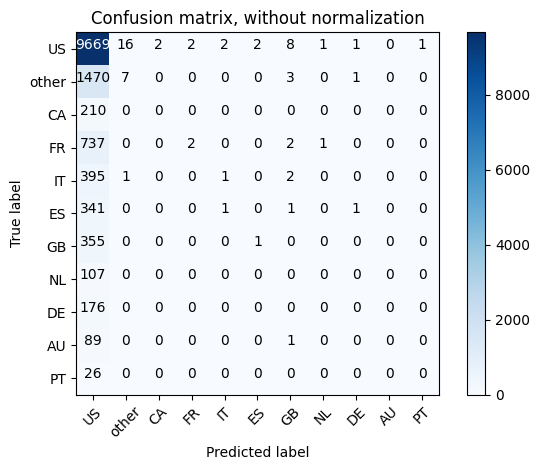

In [27]:
cnf_matrix = confusion_matrix(ytest_nn, yhat_nn,labels=y.unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y.unique(),
                      title='Confusion matrix, without normalization')

In [30]:
# generate k-fold
num_folds = 5
kfold = StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( Xtrain, ytrain ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    Xtrain_fold = Xtrain.iloc[train_ix]
    ytrain_fold = ytrain.iloc[train_ix]
    
    x_val_fold = Xtrain.iloc[val_ix]
    y_val_fold = ytrain.iloc[val_ix]
    
    # target hot-encoding
    ohe = OneHotEncoder()
    ytrain_fold_nn = ohe.fit_transform( ytrain_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=Xtrain.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( Xtrain_fold, ytrain_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 2/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 3/5
341/341 [==============================] - 1s 2ms/step
Fold Number: 4/5
341/341 [==============================] - 1s 1ms/step
Fold Number: 5/5
341/341 [==============================] - 0s 1ms/step


In [ ]:
print( np.mean( balanced_acc_list), np.std( balanced_acc_list))
print( np.mean( kappa_acc_list), np.std( kappa_acc_list))